DEMATEL Results:
               Enabler  Prominence  Relation   Type
      P3: ZEV policies      1.7115    1.1835  Cause
 P2: Charging mandates      1.6549    1.3238  Cause
P1: Purchase subsidies      1.3195    0.6836  Cause
  I1: Charging density      1.2465   -0.3675 Effect
     I2: Grid capacity      0.9813   -0.8746 Effect
     T2: Fast-charging      0.9516   -0.0495 Effect
      T1: Battery cost      0.8720    0.1095  Cause
         C1: Awareness      0.8703   -0.5842 Effect
             T3: Range      0.7967    0.0181  Cause
I3: Cross-sector coord      0.7429   -0.2647 Effect
    E1: Fleet programs      0.6362   -0.4640 Effect
  C2: Social influence      0.5498   -0.3554 Effect
  C3: TCO transparency      0.3285   -0.0703 Effect
E2: Second-hand market      0.2883   -0.2883 Effect

ISM Hierarchy Levels:
Level 1: ['E1: Fleet programs', 'E2: Second-hand market']
Level 2: ['C1: Awareness', 'C2: Social influence', 'C3: TCO transparency']
Level 3: ['I1: Charging density', 'I2: Grid cap

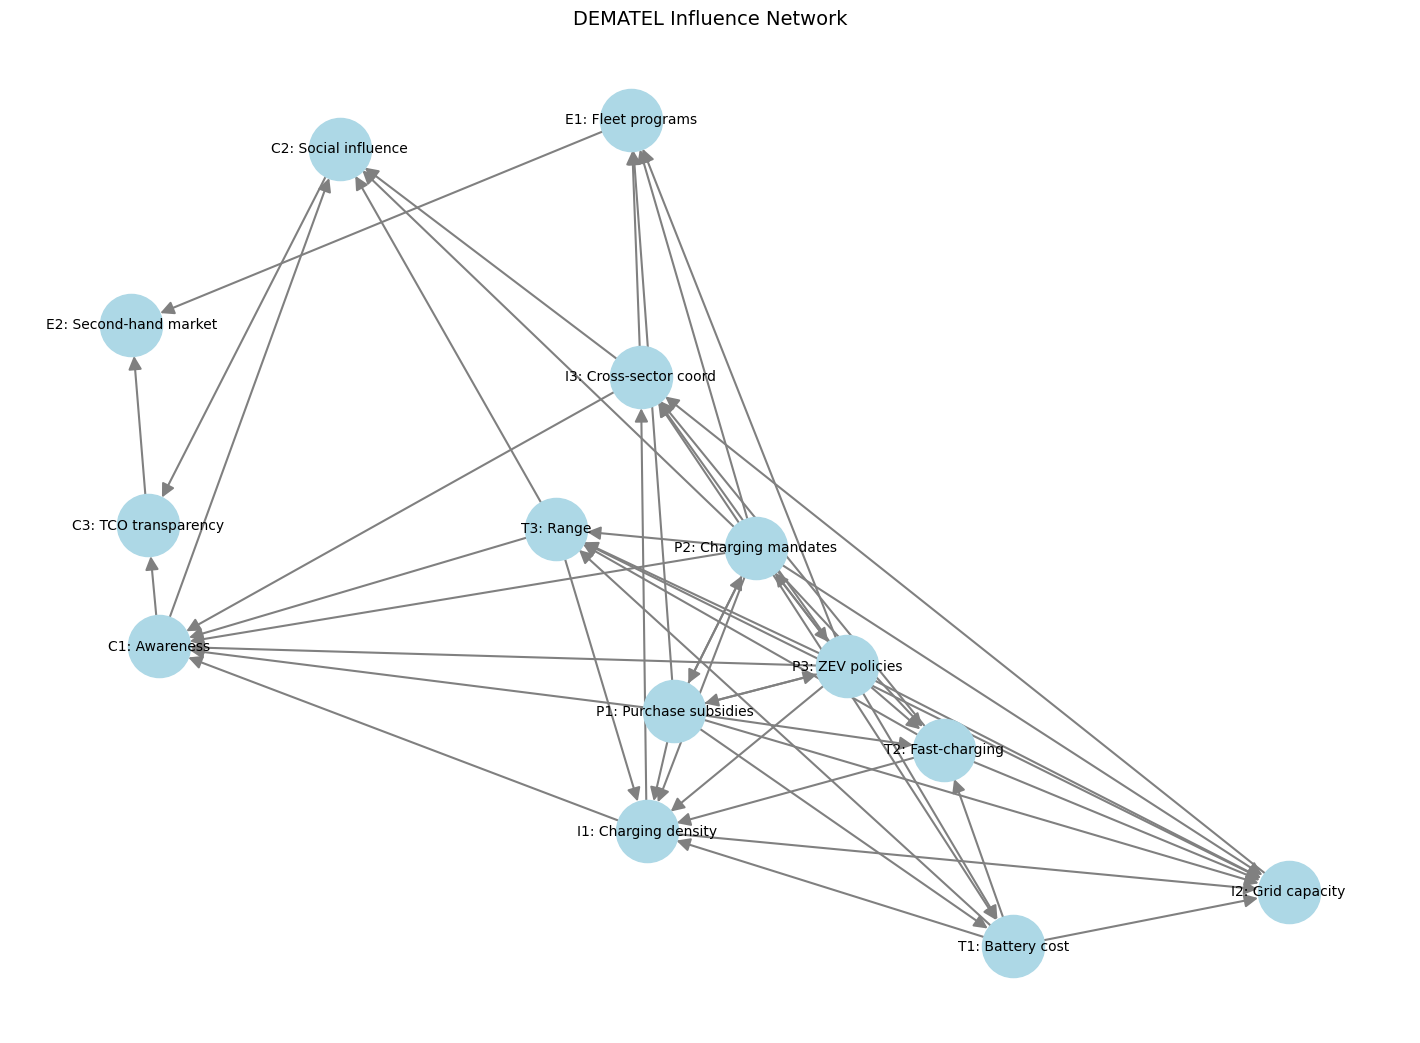

<ipython-input-1-10733067fc04>:219: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


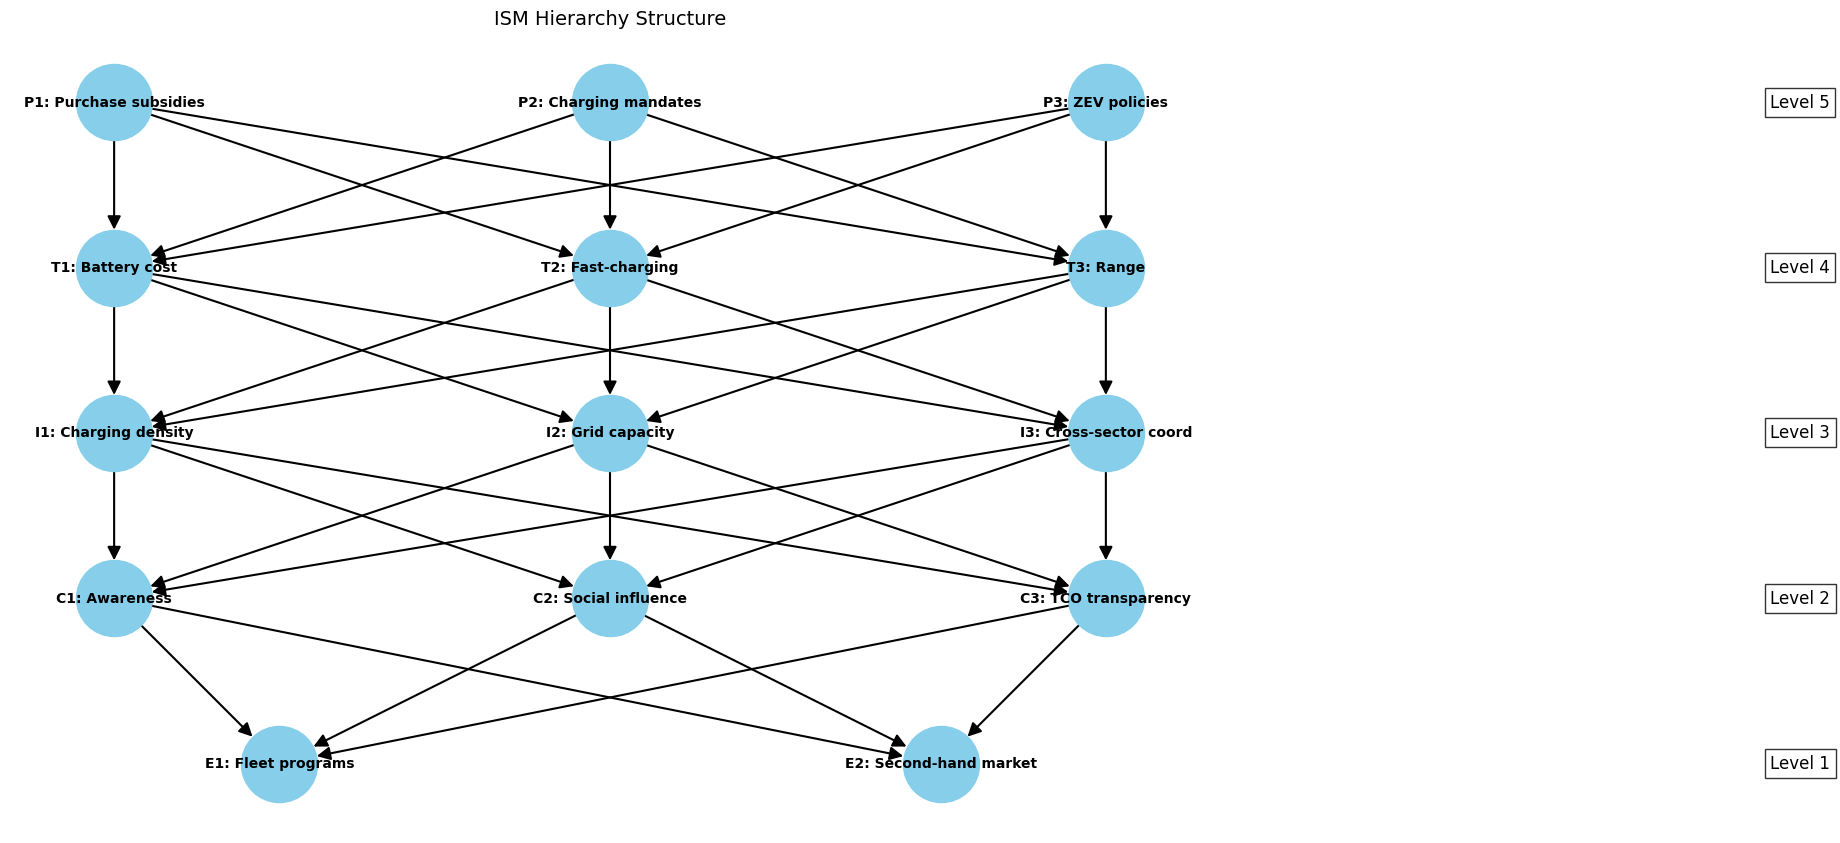

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
# --------------------------------------
# Step 1: Define Enablers and Z Matrix
# --------------------------------------

enablers = [
    'P1: Purchase subsidies', 'P2: Charging mandates', 'P3: ZEV policies',
    'T1: Battery cost', 'T2: Fast-charging', 'T3: Range',
    'I1: Charging density', 'I2: Grid capacity', 'I3: Cross-sector coord',
    'C1: Awareness', 'C2: Social influence', 'C3: TCO transparency',
    'E1: Fleet programs', 'E2: Second-hand market'
]
Z = np.array([
    [0, 1, 2, 2, 4, 0, 1, 0, 0, 4, 0, 0, 1, 0],  # P1
    [2, 0, 3, 1, 2, 4, 2, 1, 4, 0, 0, 0, 4, 0],  # P2
    [4, 2, 0, 4, 1, 0, 4, 4, 0, 0, 0, 0, 3, 0],  # P3
    [0, 0, 0, 0, 2, 1, 2, 4, 0, 0, 0, 0, 0, 0],  # T1
    [0, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0],  # T2
    [0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 4, 0, 0, 0],  # T3
    [0, 0, 0, 0, 0, 0, 0, 3, 2, 4, 0, 0, 0, 0],  # I1
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # I2
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0],  # I3
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0],  # C1
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],  # C2
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],  # C3
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],  # E1
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # E2
])

# --------------------------------------
# Step 2: DEMATEL
# --------------------------------------

def dematel(Z):
    norm_factor = max(np.max(np.sum(Z, axis=0)), np.max(np.sum(Z, axis=1)))
    X = Z / norm_factor
    if np.max(np.sum(X, axis=1)) >= 1:
        X = 0.99 * X / np.max(np.sum(X, axis=1))
    I = np.identity(len(X))
    T = np.dot(X, inv(I - X))
    R = np.sum(T, axis=1)
    C = np.sum(T, axis=0)
    prominence = R + C
    relation = R - C
    return T, prominence, relation

T, prominence, relation = dematel(Z)

dematel_df = pd.DataFrame({
    'Enabler': enablers,
    'Prominence': np.round(prominence, 4),
    'Relation': np.round(relation, 4),
    'Type': ['Cause' if r > 0 else 'Effect' for r in relation]
}).sort_values('Prominence', ascending=False)

print("DEMATEL Results:")
print(dematel_df.to_string(index=False))

# --------------------------------------
# Step 3: ISM (Improved)
# --------------------------------------

def ism_fixed_levels(T, n_levels=5):
    # threshold = np.percentile(T, 45)
    threshold = np.median(T)  # Using median for better threshold
    binary = (T >= threshold).astype(int)
    np.fill_diagonal(binary, 1)

    # Compute reachability matrix (transitive closure)
    reach = binary.copy()
    for _ in range(len(T)):
        reach = np.dot(reach, reach)
        reach = (reach > 0).astype(int)

    # Initial level derivation
    levels = []
    remaining = set(range(len(T)))
    while remaining:
        current_level = []
        for i in remaining:
            reach_set = {j for j in range(len(T)) if reach[i, j]}
            antecedent_set = {j for j in range(len(T)) if reach[j, i]}
            intersection = reach_set & antecedent_set
            if reach_set == intersection:
                current_level.append(i)
        if not current_level:
            current_level = list(remaining)
        levels.append(current_level)
        remaining -= set(current_level)

    # Flatten and redistribute into exactly n_levels
    flat = [idx for level in reversed(levels) for idx in level]
    chunk_size = max(1, int(np.ceil(len(flat) / n_levels)))
    fixed_levels = [flat[i:i + chunk_size] for i in range(0, len(flat), chunk_size)]

    # Ensure exactly n_levels (merge last levels if needed)
    while len(fixed_levels) > n_levels:
        fixed_levels[-2].extend(fixed_levels.pop())
    while len(fixed_levels) < n_levels:
        largest = max(fixed_levels, key=len)
        half = len(largest) // 2
        fixed_levels.remove(largest)
        fixed_levels.append(largest[:half])
        fixed_levels.append(largest[half:])

    return fixed_levels


ism_levels = ism_fixed_levels(T)

print("\nISM Hierarchy Levels:")
for i, level in enumerate(reversed(ism_levels)):
    print(f"Level {i+1}: {[enablers[idx] for idx in level]}")

# --------------------------------------
# Step 4: ANP
# --------------------------------------

def anp(T, clusters):
    cluster_indices = {c: [enablers.index(e) for e in es] for c, es in clusters.items()}
    n = len(enablers)
    supermatrix = np.zeros((n, n))

    for from_cluster, from_ids in cluster_indices.items():
        for to_cluster, to_ids in cluster_indices.items():
            block = T[np.ix_(to_ids, from_ids)]
            col_sum = block.sum(axis=0)
            col_sum[col_sum == 0] = 1
            normalized = block / col_sum
            supermatrix[np.ix_(to_ids, from_ids)] = normalized

    limit_matrix = supermatrix.copy()
    for _ in range(100):
        next_matrix = np.dot(limit_matrix, limit_matrix)
        if np.allclose(next_matrix, limit_matrix, atol=1e-6):
            break
        limit_matrix = next_matrix

    eigvals, eigvecs = np.linalg.eig(limit_matrix.T)
    max_idx = np.argmax(np.real(eigvals))
    weights = np.real(eigvecs[:, max_idx])
    weights = weights / np.sum(weights)
    return weights

clusters = {
    'Policy': ['P1: Purchase subsidies', 'P2: Charging mandates', 'P3: ZEV policies'],
    'Technology': ['T1: Battery cost', 'T2: Fast-charging', 'T3: Range'],
    'Infrastructure': ['I1: Charging density', 'I2: Grid capacity', 'I3: Cross-sector coord'],
    'Consumer': ['C1: Awareness', 'C2: Social influence', 'C3: TCO transparency'],
    'Economic': ['E1: Fleet programs', 'E2: Second-hand market']
}

weights = anp(T, clusters)
anp_df = pd.DataFrame({'Enabler': enablers, 'Weight': np.round(weights, 4)})
anp_df = anp_df.sort_values('Weight', ascending=False)

print("\nANP Weights:")
print(anp_df.to_string(index=False))

# --------------------------------------
# Optional: DEMATEL Influence Network
# --------------------------------------

G = nx.DiGraph()
for i, e in enumerate(enablers):
    G.add_node(e)
threshold = np.mean(T)
for i in range(len(T)):
    for j in range(len(T)):
        if T[i, j] > threshold and i != j:
            G.add_edge(enablers[i], enablers[j], weight=T[i, j])

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.6, iterations=100)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000,
        font_size=10, edge_color='gray', arrowsize=20, width=1.5)
plt.title("DEMATEL Influence Network", fontsize=14)
plt.show()

# Create a directed graph for ISM
G_ism = nx.DiGraph()

# Add edges based on the hierarchy (lower levels influence higher levels)
for i in range(len(ism_levels)-1):
    for upper_node in ism_levels[i]:
        for lower_node in ism_levels[i+1]:
            G_ism.add_edge(enablers[upper_node], enablers[lower_node])

# Create a layered layout
pos = {}
level_height = 1.0
level_spacing = 1.0 / (len(ism_levels) + 1)

for i, level in enumerate(reversed(ism_levels)):
    y_pos = level_spacing * (i + 1)
    level_width = 1.0 / (len(level) + 1)
    for j, node_idx in enumerate(level):
        x_pos = (j + 1) * level_width
        pos[enablers[node_idx]] = (x_pos, y_pos)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G_ism, pos, with_labels=True, node_size=3000, node_color='skyblue',
        font_size=10, font_weight='bold', arrowsize=20, width=1.5)

# Add level labels
for i, level in enumerate(reversed(ism_levels)):
    y_pos = level_spacing * (i + 1)
    plt.text(1.1, y_pos, f'Level {i+1}', fontsize=12, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8))

plt.title("ISM Hierarchy Structure", fontsize=14)
plt.tight_layout()
plt.show()





In [ ]:

import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# --------------------------------------
# Step 1: Define Enablers and Z Matrix
# --------------------------------------

enablers = [
    'P1: Purchase subsidies', 'P2: Charging mandates', 'P3: ZEV policies',
    'T1: Battery cost', 'T2: Fast-charging', 'T3: Range',
    'I1: Charging density', 'I2: Grid capacity', 'I3: Cross-sector coord',
    'C1: Awareness', 'C2: Social influence', 'C3: TCO transparency',
    'E1: Fleet programs', 'E2: Second-hand market'
]
Z = np.array([
    [0, 1, 2, 2, 4, 0, 1, 0, 0, 4, 0, 0, 1, 0],
    [2, 0, 3, 1, 2, 4, 2, 1, 4, 0, 0, 0, 4, 0],
    [4, 2, 0, 4, 1, 0, 4, 4, 0, 0, 0, 0, 3, 0],
    [0, 0, 0, 0, 2, 1, 2, 4, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 4, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 3, 2, 4, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])

# --------------------------------------
# Step 2: DEMATEL
# --------------------------------------

def dematel(Z):
    norm_factor = max(np.max(np.sum(Z, axis=0)), np.max(np.sum(Z, axis=1)))
    X = Z / norm_factor
    if np.max(np.sum(X, axis=1)) >= 1:
        X = 0.99 * X / np.max(np.sum(X, axis=1))

    print("Step 2: Normalized Direct Influence Matrix (X):")
    print(np.round(X, 4))

    I = np.identity(len(X))
    T = np.dot(X, inv(I - X))

    print("\nStep 2: Total Relation Matrix (T):")
    print(np.round(T, 4))

    R = np.sum(T, axis=1)
    C = np.sum(T, axis=0)
    prominence = R + C
    relation = R - C
    return T, prominence, relation

T, prominence, relation = dematel(Z)

dematel_df = pd.DataFrame({
    'Enabler': enablers,
    'Prominence': np.round(prominence, 4),
    'Relation': np.round(relation, 4),
    'Type': ['Cause' if r > 0 else 'Effect' for r in relation]
}).sort_values('Prominence', ascending=False)

print("\nDEMATEL Results:")
print(dematel_df.to_string(index=False))

# --------------------------------------
# Step 3: ISM (Improved)
# --------------------------------------

def ism_fixed_levels(T, n_levels=5):
    threshold = np.median(T)
    binary = (T >= threshold).astype(int)
    np.fill_diagonal(binary, 1)

    print("\nStep 3: Binary Reachability Matrix (Threshold {:.4f}):".format(threshold))
    print(binary)

    # Compute reachability matrix (transitive closure)
    reach = binary.copy()
    for _ in range(len(T)):
        reach = np.dot(reach, reach)
        reach = (reach > 0).astype(int)

    print("\nStep 3: Transitive Closure (Reachability Matrix):")
    print(reach)

    # Initial level derivation
    levels = []
    remaining = set(range(len(T)))
    while remaining:
        current_level = []
        for i in remaining:
            reach_set = {j for j in range(len(T)) if reach[i, j]}
            antecedent_set = {j for j in range(len(T)) if reach[j, i]}
            intersection = reach_set & antecedent_set
            if reach_set == intersection:
                current_level.append(i)
        if not current_level:
            current_level = list(remaining)
        levels.append(current_level)
        remaining -= set(current_level)

    # Flatten and redistribute into exactly n_levels
    flat = [idx for level in reversed(levels) for idx in level]
    chunk_size = max(1, int(np.ceil(len(flat) / n_levels)))
    fixed_levels = [flat[i:i + chunk_size] for i in range(0, len(flat), chunk_size)]

    # Ensure exactly n_levels
    while len(fixed_levels) > n_levels:
        fixed_levels[-2].extend(fixed_levels.pop())
    while len(fixed_levels) < n_levels:
        largest = max(fixed_levels, key=len)
        half = len(largest) // 2
        fixed_levels.remove(largest)
        fixed_levels.append(largest[:half])
        fixed_levels.append(largest[half:])

    return fixed_levels

ism_levels = ism_fixed_levels(T)

print("\nISM Hierarchy Levels:")
for i, level in enumerate(reversed(ism_levels)):
    print(f"Level {i+1}: {[enablers[idx] for idx in level]}")

# --------------------------------------
# Step 4: ANP
# --------------------------------------

def anp(T, clusters):
    cluster_indices = {c: [enablers.index(e) for e in es] for c, es in clusters.items()}
    n = len(enablers)
    supermatrix = np.zeros((n, n))

    for from_cluster, from_ids in cluster_indices.items():
        for to_cluster, to_ids in cluster_indices.items():
            block = T[np.ix_(to_ids, from_ids)]
            col_sum = block.sum(axis=0)
            col_sum[col_sum == 0] = 1
            normalized = block / col_sum
            supermatrix[np.ix_(to_ids, from_ids)] = normalized

    print("\nStep 4: Initial Supermatrix:")
    print(np.round(supermatrix, 4))

    limit_matrix = supermatrix.copy()
    for _ in range(100):
        next_matrix = np.dot(limit_matrix, limit_matrix)
        if np.allclose(next_matrix, limit_matrix, atol=1e-6):
            break
        limit_matrix = next_matrix

    print("\nStep 4: Limit Matrix (After Convergence):")
    print(np.round(limit_matrix, 4))

    eigvals, eigvecs = np.linalg.eig(limit_matrix.T)
    max_idx = np.argmax(np.real(eigvals))
    weights = np.real(eigvecs[:, max_idx])
    weights = weights / np.sum(weights)
    return weights

clusters = {
    'Policy': ['P1: Purchase subsidies', 'P2: Charging mandates', 'P3: ZEV policies'],
    'Technology': ['T1: Battery cost', 'T2: Fast-charging', 'T3: Range'],
    'Infrastructure': ['I1: Charging density', 'I2: Grid capacity', 'I3: Cross-sector coord'],
    'Consumer': ['C1: Awareness', 'C2: Social influence', 'C3: TCO transparency'],
    'Economic': ['E1: Fleet programs', 'E2: Second-hand market']
}

weights = anp(T, clusters)
anp_df = pd.DataFrame({'Enabler': enablers, 'Weight': np.round(weights, 4)})
anp_df = anp_df.sort_values('Weight', ascending=False)

print("\nANP Weights:")
print(anp_df.to_string(index=False))


Step 2: Normalized Direct Influence Matrix (X):
[[0.     0.043  0.0861 0.0861 0.1722 0.     0.043  0.     0.     0.1722
  0.     0.     0.043  0.    ]
 [0.0861 0.     0.1291 0.043  0.0861 0.1722 0.0861 0.043  0.1722 0.
  0.     0.     0.1722 0.    ]
 [0.1722 0.0861 0.     0.1722 0.043  0.     0.1722 0.1722 0.     0.
  0.     0.     0.1291 0.    ]
 [0.     0.     0.     0.     0.0861 0.043  0.0861 0.1722 0.     0.
  0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.0861 0.1291 0.0861 0.043  0.
  0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.0861 0.043  0.     0.043
  0.1722 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.1291 0.0861 0.1722
  0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.043  0.
  0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0861
  0.043  0.     0.0861 0.    ]
 [0.     0.     0.     0.     0.     0.     0.